# Machine Learning and Predictive Analysis - Final Project

## 1) Problem Statement: 

The 10-year U.S. Treasury note is arguably the most important financial asset in the world: whether its from the perspective of the U.S. government (how much does it cost the U.S. tax payer to fund the government for 10-years), or for private borrowers (who will have to pay a spread, a premium, to the risk-free rate (aka U.S. Treasury  Yields)), or for M&A and banking activities that rely on 10-year borrowing costs to come up with valuation models, and of course for traders and portfolio managers who speculate on the price-trajectory of U.S. sovereign government debt, there are few -- if any -- macroeconomic / financial variables that are more closely watched than the yield to maturity on the current U.S. Treasury 10-year note. 

As such, coming up with multiple analytical frameworks for the estimation and direction of where the 10-year treasury note is headed, is intuitively critically important for industry participants, regardless of her role (as dictated above). As a current trader / portfolio manager in U.S. fixed income space (and an aspiring Fed / Treasury official in the future who would wanat to approach forecasting of future treasury yields from an issuance / policy management lens), having a data-driven approach to such an estimation is crucial and hyper-beneficial. 

**In short, for this final project, I looked to answer the question(s): for i in range(1,n): f"Where will be 10-year U.S. Treasury Closing Yields be {i} days from now?"** 

To answer the above, I created a deep-learning neural network model that takes advtange of seasonality trends and autocorrelation -- using no extraneous variables other than features-engineered from the price history itself -- to predict future price action. 

## 2) Assumptions / Hypotheses About Data and Model: 

Although assumptions and hypotheses about the data abound, a few key assumptions and hypotheses made when creating this model are outlined below: 

- The first key assumption is that in 'trend-following' assets like macro variables and commodities (interest rates, FX, Commodity), there is a certain temporal dependence that could be captured in auto-regressive models like ARIMA models or other models that regress lagged data. I wanted to investigate whether Recurrent Neural Networks with LSTMs could be smarter than ARIMA models in forecasting time-series data by expanding the capacity with which these temporal relationships are analyzed. 

- The second key assumption is that given this is a time-series model, and randomly shuffling the data-set before creating a train-test split defeats the purpose of analyzing time series data, that the temporal relationship analyzed in the training set, at least to an extent, is maintained in the test / validation sets as well. Otherwise, the model would not be generalizing well, and our analytical framework for predicting future price patterns would deteriorate. 

- There are also certain drawbacks to a model like this. Although there is a major benefit in the simplicity of running a univariate model, as we will see, univariate models tend to get lost in autocorrelation (after running the univariate model multiple times, the RNN just thought that the ongoing 'trend' would follow for the next 10 days to some kind of extent). When creating dummy variables to account for seasonality (Day of the week, Month, Week Number in the year, etc.) we see dramatic improvement, but only at the expense of computational cost and time...

- Finally, given the U.S. 10-year yield is one of the most prolific / famous assets in financial history, data-abundance was not an issue (was able to find without problem 35 years of daily price data). That being said, in the 80s, record-keeping techniques were not nearly where they are right now, and as such, there are many missing data points, particularly in the beginning of the time series. To account for this, after considering Rolling Mean Imputation (intuitition makes sense), KNN Imputation, and multivariate imputation using dummy variables for day of week / day of month / month, I have decided to use linear-imputation as a technique to 'complete' the data. As an industry professional, I find that linear imputation is probably the most realistic given a) the trend-following nature of the 10-year yield and b) the moving average's inability to properly account for micro trends / trend shifts in a granular and effective way. 

### Import Necessary Libraries

In [1]:
#Python Basics
import math
import numpy as np
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

#Plotting
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

#Statsmodels
import statsmodels 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

#SKLearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Keras 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

#Miscellanious
import yfinance as yf
from yahoo_fin.stock_info import get_data

#Set Seed
from numpy.random import seed
seed(123456789)

## 3) Exploratory Data Analysis / Data Cleaning

Download Maximum available data for 10-year yield history from Yahoo-Finance: 

In [2]:
ten_yield = get_data("^TNX", start_date = "1/1/1985", end_date = "12/6/2023",
                    index_as_date = True, interval = "1d")

In [3]:
ten_yield.tail(10)

,open,high,low,close,adjclose,volume,ticker
2023-11-24,4.474,4.492,4.463,4.472,4.472,0.0,^TNX
2023-11-26,NaN,NaN,NaN,NaN,NaN,NaN,^TNX
2023-11-27,4.457,4.461,4.389,4.389,4.389,0.0,^TNX
2023-11-28,4.396,4.422,4.332,4.336,4.336,0.0,^TNX
2023-11-29,4.294,4.323,4.253,4.271,4.271,0.0,^TNX
2023-11-30,4.280,4.352,4.272,4.352,4.352,0.0,^TNX
2023-12-01,4.320,4.348,4.211,4.226,4.226,0.0,^TNX
2023-12-03,NaN,NaN,NaN,NaN,NaN,NaN,^TNX
2023-12-04,4.243,4.299,4.240,4.288,4.288,0.0,^TNX
2023-12-05,4.226,4.228,4.165,4.171,4.171,0.0,^TNX


Isolate to close price values (which will be our univariate data) and search for number of missing values:

In [4]:
#Investigate Missing Values
ten_yield_close = ten_yield[['close']]
print(ten_yield_close.isna().sum())
print(ten_yield_close.shape)

close    2271
dtype: int64
(12035, 1)


First, lets start out by getting rid of saturdays and sundays where market is closed (potentially creating NaN Values)

In [5]:
#Rename the dataframe for ease of use:
df = pd.DataFrame(ten_yield_close)

#Name the index to 'Date':
df.index.names = ['Date']

#Set the time series data frequency to daily: 
df = df.asfreq('B')

#Create Weekday Feature (will use this to create dummy variables later as well)
df['Weekday'] = df.index.day_name()

#Drop Saturdays and Sundays
index_names = df[ (df['Weekday'] == 'Sunday') | (df['Weekday'] == 'Saturday')].index 
df.drop(index_names, inplace = True) 

#Investigate Clarity: 
df = pd.DataFrame(df)
df.head(10)

,close,Weekday
Date,,
1985-01-02,11.70,Wednesday
1985-01-03,11.62,Thursday
1985-01-04,11.67,Friday
1985-01-07,11.50,Monday
1985-01-08,11.45,Tuesday
1985-01-09,11.47,Wednesday
1985-01-10,11.48,Thursday
1985-01-11,11.59,Friday
1985-01-14,11.60,Monday


In [6]:
#Now let us count NA values... 
print(df.isna().sum())

close      391
Weekday      0
dtype: int64


As discussed in model assumptions, we will go with Linear Imputation, and confirm we have no more NA values... 

In [7]:
df_fillna = df.interpolate(method = 'linear')
print(df_fillna.isna().sum())
df_fillna.tail(10)

close      0
Weekday    0
dtype: int64


,close,Weekday
Date,,
2023-11-22,4.416,Wednesday
2023-11-23,4.444,Thursday
2023-11-24,4.472,Friday
2023-11-27,4.389,Monday
2023-11-28,4.336,Tuesday
2023-11-29,4.271,Wednesday
2023-11-30,4.352,Thursday
2023-12-01,4.226,Friday
2023-12-04,4.288,Monday


In [8]:
#Change frequency of the data to business-days: 
df_fillna = df_fillna.asfreq('B')
df_fillna.isna().sum()

close      0
Weekday    0
dtype: int64

Text(0.5, 0, 'Date')

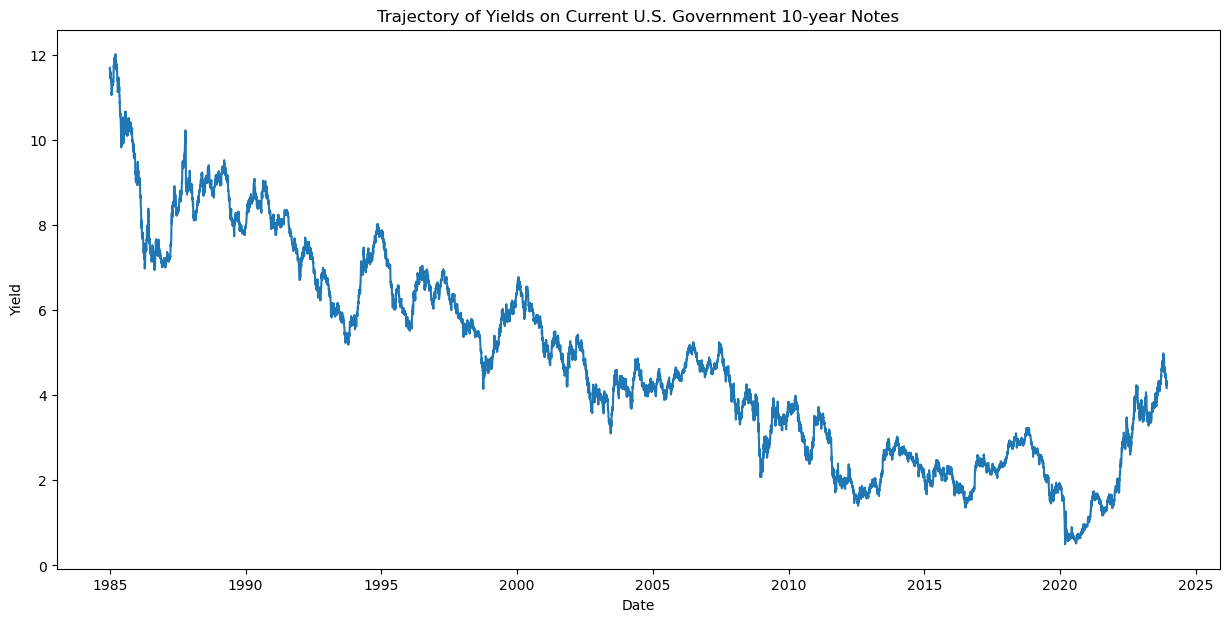

In [9]:
#Try Charting 10y Yields over the course of its 38 year history...
plt.figure(figsize = (15, 7))
plt.plot(df_fillna['close'])
plt.title("Trajectory of Yields on Current U.S. Government 10-year Notes")
plt.ylabel('Yield')
plt.xlabel('Date')

We can investigate the seasonal decomposition to see if we can use monthly dummy variables as a potential input later in our 'multivariate' RNN model... 

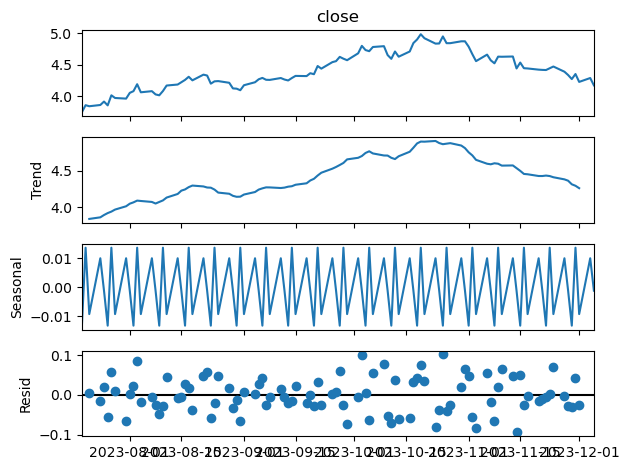

In [10]:
#Looking at the last 100 days, there seems to be clear monthly seasonal decomposition... 
sd = seasonal_decompose(df_fillna['close'].tail(100))
sd.plot()
plt.show()

It feels as though across time, 10-year notes exhibit both a micro-seasonality as well as large macro-aggregate trends. As a student of economics, I can confirm less rigorously that this is indeed true, but good to see the behavior (to an extent) in such a seasonal decomposition as well. 

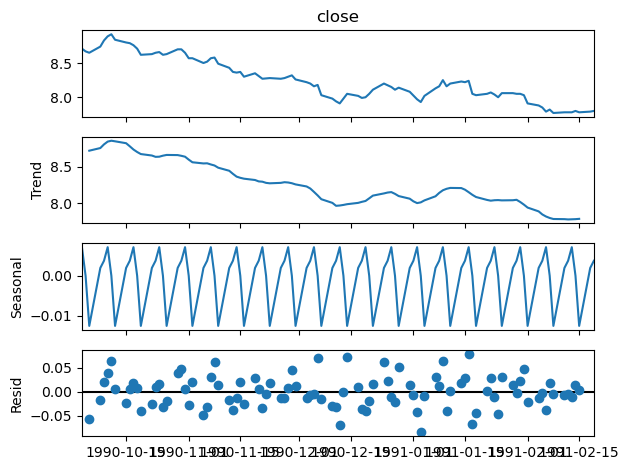

In [11]:
#looking at random intervals also shows some seasonality 
sd = seasonal_decompose(df_fillna['close'].iloc[1500:1600])
sd.plot()
plt.show()

As previously discussed... Macro-Financial instruments like U.S. Treasuries are trend following instruments. As such, would be interesting to run an autocorrelation analysis on 10y US treasury yields going back to 1985. 

<Axes: xlabel='y(t)', ylabel='y(t + 9)'>

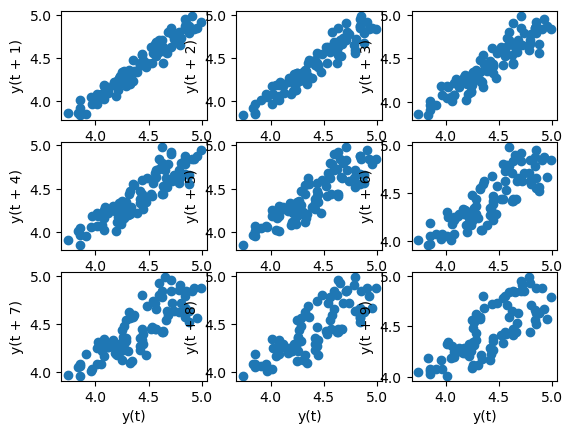

In [12]:
#First look at a lagged plot of up to 10 days:

fig, axes = plt.subplots(nrows=3, ncols=3)
pd.plotting.lag_plot(df_fillna['close'].tail(100), lag = 1, ax = axes[0,0])
pd.plotting.lag_plot(df_fillna['close'].tail(100), lag = 2, ax = axes[0,1])
pd.plotting.lag_plot(df_fillna['close'].tail(100), lag = 3, ax = axes[0,2])
pd.plotting.lag_plot(df_fillna['close'].tail(100), lag = 4, ax = axes[1,0])
pd.plotting.lag_plot(df_fillna['close'].tail(100), lag = 5, ax = axes[1,1])
pd.plotting.lag_plot(df_fillna['close'].tail(100), lag = 6, ax = axes[1,2])
pd.plotting.lag_plot(df_fillna['close'].tail(100), lag = 7, ax = axes[2,0])
pd.plotting.lag_plot(df_fillna['close'].tail(100), lag = 8, ax = axes[2,1])
pd.plotting.lag_plot(df_fillna['close'].tail(100), lag = 9, ax = axes[2,2])

In [13]:
#Lets examine the table of correlations with lagged values. 

values = pd.DataFrame(df_fillna['close'].values)
auto_corr = pd.concat([values.shift(9), values.shift(8), values.shift(7), values.shift(6),values.shift(5),
                      values.shift(4),values.shift(3),values.shift(2),values.shift(1), values], axis = 1)
auto_corr.columns = ['t', 't+1', 't+2', 't+3', 't+4',
                     't+5', 't+6', 't+7', 't+8', 't+9']

result = auto_corr.corr()
result

,t,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9
t,1.000000,0.999707,0.999387,0.999076,0.998772,0.998476,0.998185,0.997903,0.997611,0.997319
t+1,0.999707,1.000000,0.999707,0.999387,0.999076,0.998772,0.998476,0.998185,0.997903,0.997610
t+2,0.999387,0.999707,1.000000,0.999707,0.999387,0.999076,0.998772,0.998475,0.998184,0.997902
t+3,0.999076,0.999387,0.999707,1.000000,0.999707,0.999387,0.999076,0.998772,0.998475,0.998184
t+4,0.998772,0.999076,0.999387,0.999707,1.000000,0.999707,0.999387,0.999076,0.998772,0.998475
t+5,0.998476,0.998772,0.999076,0.999387,0.999707,1.000000,0.999707,0.999387,0.999076,0.998772
t+6,0.998185,0.998476,0.998772,0.999076,0.999387,0.999707,1.000000,0.999707,0.999387,0.999075
t+7,0.997903,0.998185,0.998475,0.998772,0.999076,0.999387,0.999707,1.000000,0.999707,0.999387
t+8,0.997611,0.997903,0.998184,0.998475,0.998772,0.999076,0.999387,0.999707,1.000000,0.999707
t+9,0.997319,0.997610,0.997902,0.998184,0.998475,0.998772,0.999075,0.999387,0.999707,1.000000


Autocorrelation intuition is confirmed... 1) there is incredibly strong / high levels of auto_correlation, and 2) you see a gradual decrease in autocorrelation as you extend further out from the spot date (but by such a little margin...). Wonder if we can see such in an ACF function... 

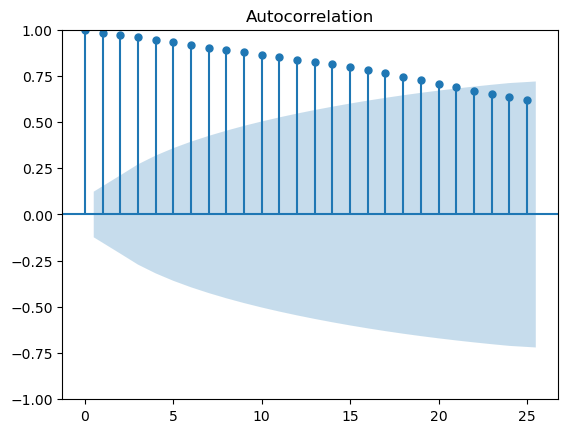

In [14]:
#Even just looking at the last 252 days (trading days in a year), very high autocorrelation is evident... 
acf = plot_acf(df_fillna['close'].tail(252))

All of this suggests that perhaps an LSTM neural network model can actually pick up tendencies in the autocorrelation / seasonality... Let us move on to feature engineering, where we will create dummy variables for day of week, week number in the year... 

## 4) Feature Engineering / Scaling / Train-Test Splitting

Our main focus in feature engineering - other than reshaping and rescaling the data so to better fit the recurrent neural network -- is to create a series of dummy variables to further investigate seasonality of US treasuries (which as a trader, I can tell you, is hyper critical and highly scrutinized for assets like U.S. interest rate products). 

In [15]:
#Create Week Number Feature and Month Feature
df_fillna['Week_Number'] = df_fillna.index.strftime('%U')
df_fillna['Month'] = df_fillna.index.month
#df_fillna['Year'] = df_fillna.index.year
df_fillna.tail(25)

,close,Weekday,Week_Number,Month
Date,,,,
2023-11-01,4.789,Wednesday,44,11
2023-11-02,4.669,Thursday,44,11
2023-11-03,4.558,Friday,44,11
2023-11-06,4.662,Monday,45,11
2023-11-07,4.571,Tuesday,45,11
2023-11-08,4.523,Wednesday,45,11
2023-11-09,4.630,Thursday,45,11
2023-11-10,4.628,Friday,45,11
2023-11-13,4.632,Monday,46,11


Transform our Variables into object classess to more easily make into dummy variables... 

In [16]:
#Activate Label Encoder 
le = LabelEncoder()

#Fit transform each feature
label = le.fit_transform(df_fillna['Weekday'])
label2 = le.fit_transform(df_fillna['Week_Number'])
label3 = le.fit_transform(df_fillna['Month'])
#label4 = le.fit_transform(df_fillna['Year'])

#Replace data 
df_fillna['Weekday'] = np.array(label).astype(object)
df_fillna['Week_Number'] = np.array(label2).astype(object)
df_fillna['Month'] = np.array(label3).astype(object)
#df_fillna['Year'] = np.array(label4).astype(object)

#Confirm data types to get dummy variables later
df_fillna.dtypes

close          float64
Weekday         object
Week_Number     object
Month           object
dtype: object

In [17]:
#Separate Target and Features
target = df_fillna[['close']]
features = df_fillna.iloc[:,1:]
features_dummy = pd.get_dummies(features, dtype='int')

results = pd.concat([target, features_dummy.reindex(target.index)], axis=1)
results

,close,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Week_Number_0,Week_Number_1,Week_Number_2,Week_Number_3,...,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11
Date,,,,,,,,,,,,,,,,,,,,,
1985-01-02,11.700,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1985-01-03,11.620,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1985-01-04,11.670,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1985-01-07,11.500,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1985-01-08,11.450,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29,4.271,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2023-11-30,4.352,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2023-12-01,4.226,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


From here on out, we will separate the process of data-engineering between a) the data that we will use to create our univariate LSTM model, and b) our multivariate LSTM model (with dummy variables for weekly and monthly seasonality etc.)

#### Data Set Prepping for a Univariate LSTM Model (Prediction Solely Based on Time Series, No Dummy Vars)

In [18]:
#Define the regime for our LSTMs in our univariate model... 

regime = 60 #(60 days would be roughly 3 months given the lack of weekends in dataset)

#Scale and Normalize our univariate data:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(target).reshape(-1,1))

In [19]:
#Train-Test Split the Time Series

split_rat = 0.75
train_size = int(len(scaled_data) * split_rat)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]
print(train_data.shape, test_data.shape)

(7616, 1) (2539, 1)


In [20]:
x_train, y_train = [], []

#Prepare sequences for the training set:
for i in range(regime, len(train_data)):
    x_train.append(train_data[i - regime:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Prepare sequences for the test set:
x_test, y_test = [], []

for i in range(regime, len(test_data)):
    x_test.append(test_data[i - regime:i, 0])
    y_test.append(test_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

In [21]:
# Reshape input data for LSTM([samples, time steps, features]) so that it can fit our RNN: 

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

Data set prepping for a univariate model is relatively simple... no real array re-shaping, no dimensionality reduction / expansion etc. We will see this process gets a bit more complicated in our multivariate model...

#### Data Set Prepping for a Multivariate LSTM Model (Prediction Based on Post-Feature Engineered Data (Dummy Vars))

In [22]:
#Define the Regime for our LSTMs in our multivariate model:

regime_2 = 60 #(60 days would be roughly 3 months given the lack of weekends in dataset)

In [23]:
#Train-Test Split the Multivariate Time-Series
split_ratio_multivar = split_rat 
train_size_multivar = int(len(results) * split_ratio_multivar)
train_data_multivar, test_data_multivar = results[:train_size_multivar], results[train_size_multivar:]

#Scale and Normalize:
scaler_multivar = MinMaxScaler(feature_range = (0,1))
train_data_multivar = scaler_multivar.fit_transform(train_data_multivar)
test_data_multivar = scaler_multivar.fit_transform(test_data_multivar)
train_data_multivar.shape

(7616, 72)

In [24]:
def create_multivar_dataset(dataset, regime_2): 
    x_data_multivar = []
    y_data_multivar = []
    for i in range(regime_2, len(dataset)): 
        x_data_multivar.append(dataset[i-regime_2:i,0:dataset.shape[1]])
        y_data_multivar.append(dataset[i,0])
        
    return np.array(x_data_multivar), np.array(y_data_multivar)

In [25]:
x_train_multivar, y_train_multivar = create_multivar_dataset(train_data_multivar, regime_2)
x_test_multivar, y_test_multivar = create_multivar_dataset(test_data_multivar, regime_2)

#Make sure the shapes fit the format... [Observations, Look_Back, Features]
print(x_train_multivar.shape)
print(y_train_multivar.shape)
print(x_test_multivar.shape)
print(y_test_multivar.shape)

(7556, 60, 72)
(7556,)
(2479, 60, 72)
(2479,)


## 5. Proposed Approaches (Model) with checks for overfitting/underfitting

- From a big picture perspective, it makes sense to evaluate a question like this using LSTM Recurrent Neural Networks not only because large architectures can be succesfully trained, but also because Time Series data has a unique complexity of sequence dependence that regression based models - for example - are not as suited to analyze. 

- In particular, the LSTM (Long-Short-Term-Memory) model works well with this kind of problem as it is trained using  a backpropagation through time that overcomes the vanishing gradient problem (that tends to happen with neural network training with large sample sizes / with data that has longer sequences as inputs and still have temporal relationships that need to be analyzed). Thus LSTMs overcome this by creating blocks and memory for recent sequences that make it particularly well suited for analyzing time series data. 

- In addition to using LSTMs on a RNN, this model will employ a window (a regime) using recent time steps to make predictions for the next n-steps. The window is a hyper parameter that can be regularized in the future, but will be sticking with 30-60 days in our experiment, a number decided upon by using my business knowledge and recognizing that interest rate regimes in 2023 have changed every 30-60 days or so (not a scientific approach to window generation, obviously some kind of hyper-parameter tuning is far more efficient / analytical, but given the time it takes to fit these models that will be a subject for future work.

- Finally, to check for overfitting and underfitting, we will employ and plot the training and validation loss over time to see where they diverge. Just so that we don't have to run the fitting process forever, we will employ a callback (bechmark / early-stopping process) process that will automatically stop the fitting process if the process is unable to find a better model within 5 new epochs of the epoch that producest the lowest validation score (patience = 5). This is also a hyper-parameter than can be optimized for later in our further work. The loss function we are using is negative mean squared error; this metric is particularly useful in a study like this, given taking thee square root of the loss actually gives the model real life meaning (on average, how far off is the prediction from the realized level, expressed in units of the target variable). 

## 6. Proposed Solution (Model Selection) with Regularization:

#### Univariate model construction: 

In [26]:
#We Use a Sequential Model with four layers... similar to one defined in class:
model_univariate = Sequential()

# First LSTM layer with 50 units, input shape, and return sequences
model_univariate.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model_univariate.add(Dropout(0.2))         

# Second LSTM layer with 50 units and return sequences
model_univariate.add(LSTM(units=50, return_sequences=True))
model_univariate.add(Dropout(0.2))

# Third LSTM layer with 50 units
model_univariate.add(LSTM(units=50))
model_univariate.add(Dropout(0.2))

#Finally, add a dense layer 
model_univariate.add(Dense(units=1))

In [27]:
model_univariate.compile(loss='mean_squared_error',optimizer='sgd')

In [28]:
# Defining our callbacks
benchmarks = ModelCheckpoint(filepath = 'univariate_weights.h5', save_best_only = True)

# Defining early stopping so training process doesn't last forever...
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train / Fit LSTM model: 
history1 = model_univariate.fit(x_train, y_train,
          validation_data=(x_test,y_test),
          epochs=1000,
          batch_size=64,
          verbose=1,
          callbacks= [benchmarks, early_stopping])

Epoch 1/1000


2023-12-07 21:31:10.919198: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


119/119 [==============================] - 7s 50ms/step - loss: 0.0400 - val_loss: 0.0594
Epoch 2/1000
119/119 [==============================] - 6s 49ms/step - loss: 0.0188 - val_loss: 0.0251
Epoch 3/1000
119/119 [==============================] - 6s 49ms/step - loss: 0.0097 - val_loss: 0.0071
Epoch 4/1000
119/119 [==============================] - 6s 50ms/step - loss: 0.0041 - val_loss: 3.2290e-04
Epoch 5/1000
119/119 [==============================] - 6s 50ms/step - loss: 0.0026 - val_loss: 2.1656e-04
Epoch 6/1000
119/119 [==============================] - 6s 49ms/step - loss: 0.0022 - val_loss: 2.4389e-04
Epoch 7/1000
119/119 [==============================] - 6s 50ms/step - loss: 0.0022 - val_loss: 4.2771e-04
Epoch 8/1000
119/119 [==============================] - 6s 49ms/step - loss: 0.0020 - val_loss: 2.7507e-04
Epoch 9/1000
119/119 [==============================] - 6s 49ms/step - loss: 0.0020 - val_loss: 2.9110e-04
Epoch 10/1000
119/119 [==============================] - 6s 49

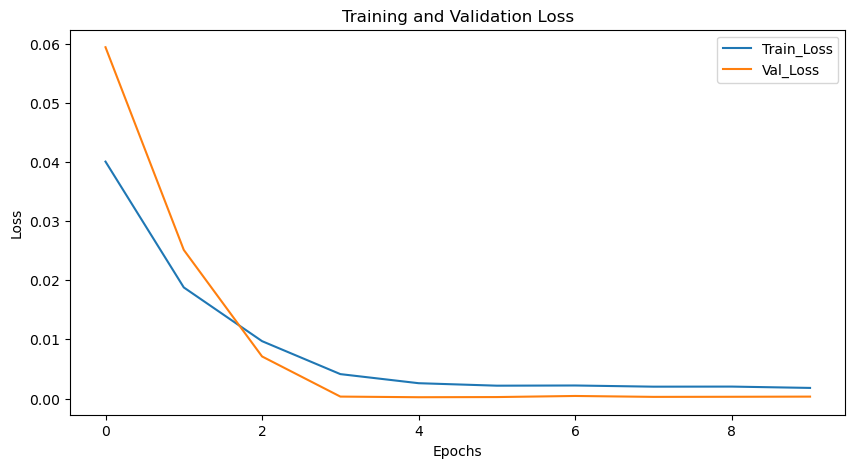

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(history1.history['loss'], label='Train_Loss')
plt.plot(history1.history['val_loss'], label='Val_Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#### Multivariate Model Construction

In [30]:
model_multivariate = Sequential()

model_multivariate.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_multivar.shape[1], x_train_multivar.shape[2])))
model_multivariate.add(Dropout(0.2))         

model_multivariate.add(LSTM(units=50, return_sequences = True))
model_multivariate.add(Dropout(0.2))

model_multivariate.add(LSTM(units=50))
model_multivariate.add(Dropout(0.2))

model_multivariate.add(Dense(units=1))

model_multivariate.compile(loss='mean_squared_error', optimizer = 'adam', run_eagerly = True)

In [31]:
# Defining our callbacks
benchmarks_multivar = ModelCheckpoint(filepath = 'multivariate_weights.h5', save_best_only = True)

# Defining early stopping so training process doesn't last forever...
early_stopping_multivar = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [32]:
history2 = model_multivariate.fit(tf.expand_dims(x_train_multivar, axis = -1), 
                       y_train_multivar, 
                       validation_data = (x_test_multivar, y_test_multivar),
                       epochs=1000,
                       batch_size=32,
                       verbose=1,
                       callbacks= [benchmarks_multivar, early_stopping_multivar]
                       )

Epoch 1/1000
237/237 [==============================] - 48s 202ms/step - loss: 0.0068 - val_loss: 0.0019
Epoch 2/1000
237/237 [==============================] - 48s 201ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 3/1000
237/237 [==============================] - 48s 202ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 4/1000
237/237 [==============================] - 48s 202ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 5/1000
237/237 [==============================] - 48s 203ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 6/1000
237/237 [==============================] - 49s 205ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 7/1000
237/237 [==============================] - 47s 200ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 8/1000
237/237 [==============================] - 48s 201ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 9/1000
237/237 [==============================] - 48s 202ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/1000
237/237 [==============================] 

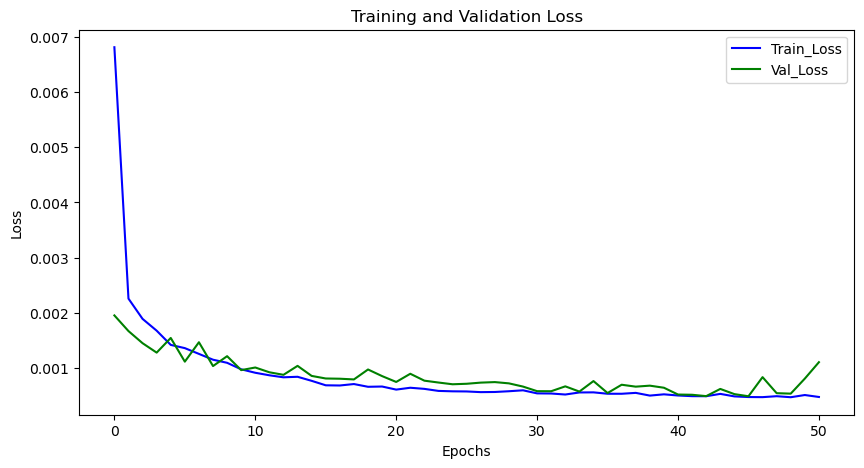

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(history2.history['loss'], label='Train_Loss', color = 'blue')
plt.plot(history2.history['val_loss'], label='Val_Loss', color = 'green')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## 7. Results (Accuracy) and Learnings from the methodology 

#### Univariate Model Prediction

In [34]:
train_predict=model_univariate.predict(x_train)
test_predict=model_univariate.predict(x_test)

train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

print(train_predict.shape, test_predict.shape)

78/78 [==============================] - 1s 7ms/step
(7556, 1) (2479, 1)


In [35]:
# Calculate train data RMSE
print("MSE For Training Data is", math.sqrt(mean_squared_error(y_train,train_predict)))

# Calculate test data RMSE
print("MSE For Testing Data is", math.sqrt(mean_squared_error(y_test,test_predict)))

MSE For Training Data is 5.514073779161283
MSE For Testing Data is 2.262798248734188


In [36]:
target_train = target.head(int(len(scaled_data) * split_rat))
target_train_p = target_train.tail(train_predict.shape[0])
target_train_p['predictions'] = train_predict

target_test = target.tail(1-int(len(scaled_data) * split_rat))
target_test_p = target_test.tail(test_predict.shape[0])
target_test_p['predictions'] = test_predict

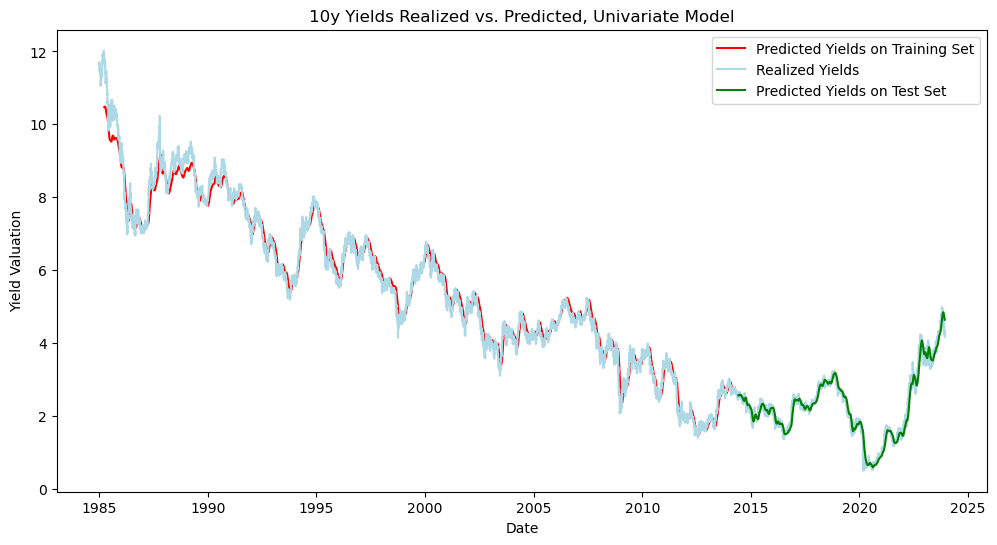

In [37]:
plt.figure(figsize = (12, 6))
#plt.plot(target_train_p['close'], color = 'lightblue', label = "Realized Yields")
plt.plot(target_train_p['predictions'], color = 'red', label = "Predicted Yields on Training Set")
plt.plot(df_fillna['close'], color = 'lightblue', label = "Realized Yields")
plt.plot(target_test_p['predictions'], color = 'green', label = "Predicted Yields on Test Set")

plt.title("10y Yields Realized vs. Predicted, Univariate Model")
plt.xlabel("Date")
plt.ylabel("Yield Valuation")
plt.legend()
plt.show()

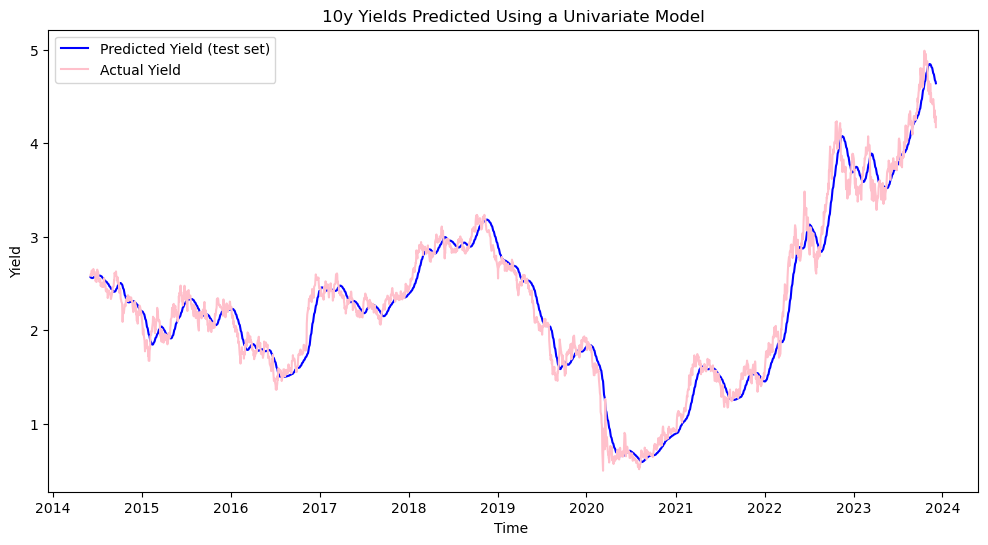

In [38]:
plt.figure(figsize = (12,6))
plt.plot(target_test_p['predictions'], color='blue', label=f"Predicted Yield (test set)")
plt.plot(target_test_p['close'], color='pink', label=f"Actual Yield")
plt.title(f"10y Yields Predicted Using a Univariate Model")
plt.xlabel("Time ")
plt.ylabel(f"Yield")
plt.legend()
plt.show()

In [39]:
last_sequence = x_test[-1]

# Reshape the last ten observations to match dimensionality of the model: 
last_sequence = last_sequence.reshape(1, regime, 1)

# Run a For-Loop for the next ten days: 
predictions_next_10_days = []
for _ in range(10):
    next_day_prediction = model_univariate.predict(last_sequence)
    predictions_next_10_days.append(next_day_prediction[0, 0])  # Get the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=1)  # Shift the sequence by one day
    last_sequence[0, -1, 0] = next_day_prediction  # Update the last element with the new prediction

#Transform back the predictions to meet scale: 
predictions_next_10_days = scaler.inverse_transform(np.array(predictions_next_10_days).reshape(-1, 1))

1/1 [==============================] - 0s 12ms/step


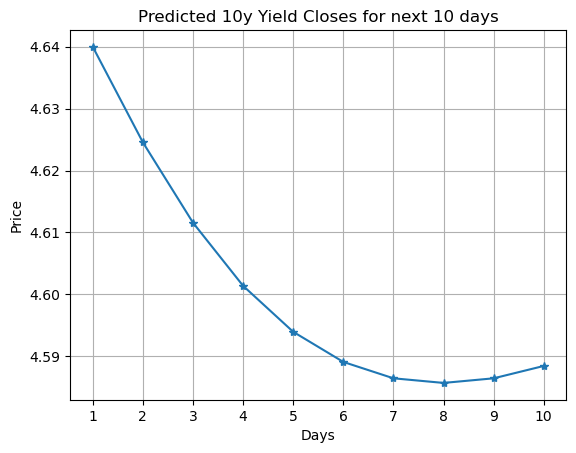

In [40]:
plt.plot(predictions_next_10_days, marker='*')
plt.title(f'Predicted 10y Yield Closes for next 10 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 10), ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.grid(True)
plt.show()

#### Multivariate Model Predictions

In [41]:
train_predict_multivar=model_multivariate.predict(x_train_multivar)
test_predict_multivar=model_multivariate.predict(x_test_multivar)

prediction_train_mv = np.repeat(train_predict_multivar, x_train_multivar.shape[2], axis = -1)
prediction_test_mv = np.repeat(test_predict_multivar, x_train_multivar.shape[2], axis = -1)

train_predict_multivar=scaler_multivar.inverse_transform(np.reshape(prediction_train_mv, (len(train_predict_multivar),x_train_multivar.shape[2])))[:,0]
test_predict_multivar=scaler_multivar.inverse_transform(np.reshape(prediction_test_mv, (len(test_predict_multivar),x_train_multivar.shape[2])))[:,0]

78/78 [==============================] - 6s 74ms/step


In [42]:
# Calculate train data RMSE
print(math.sqrt(mean_squared_error(y_train_multivar,train_predict_multivar)))

# Calculate test data RMSE
print(math.sqrt(mean_squared_error(y_test_multivar,test_predict_multivar)))

2.0229345975229074
2.0039995966984043


In [43]:
target_train_mv = target.head(int(len(scaled_data) * split_rat))
target_train_p_mv = target_train_mv.tail(train_predict_multivar.shape[0])
target_train_p_mv['predictions'] = train_predict_multivar

target_test_mv = target.tail(1-int(len(scaled_data) * split_rat))
target_test_p_mv = target_test.tail(test_predict_multivar.shape[0])
target_test_p_mv['predictions'] = test_predict_multivar

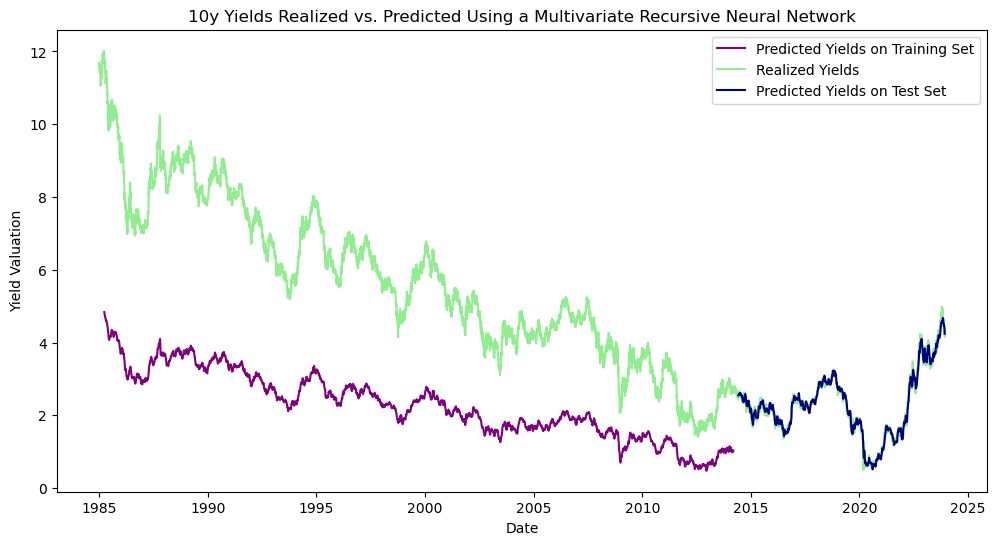

In [44]:
plt.figure(figsize = (12, 6))
#plt.plot(target_train_p['close'], color = 'lightblue', label = "Realized Yields")
plt.plot(target_train_p_mv['predictions'], color = 'purple', label = "Predicted Yields on Training Set")
plt.plot(df_fillna['close'], color = 'lightgreen', label = "Realized Yields")
plt.plot(target_test_p_mv['predictions'], color = 'navy', label = "Predicted Yields on Test Set")

plt.title("10y Yields Realized vs. Predicted Using a Multivariate Recursive Neural Network")
plt.xlabel("Date")
plt.ylabel("Yield Valuation")
plt.legend()
plt.show()

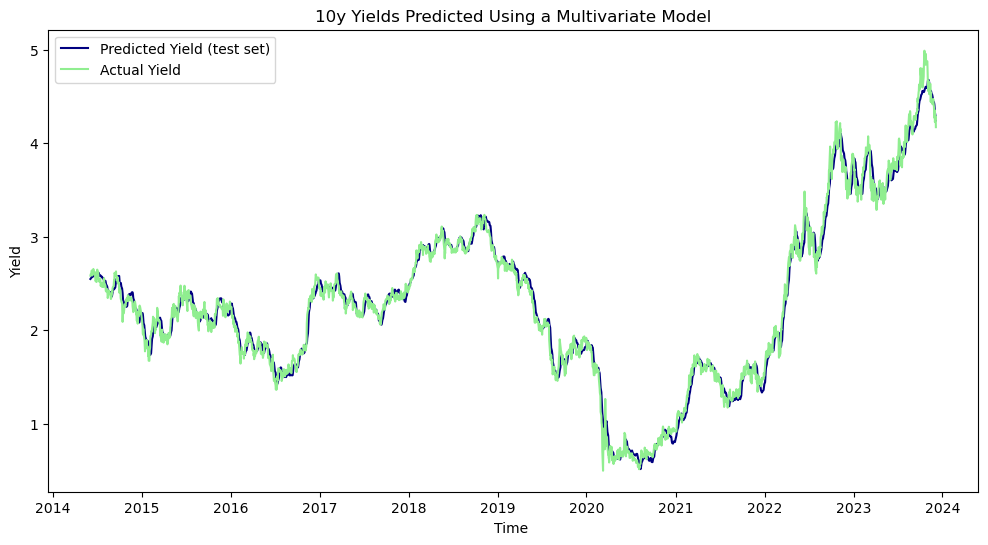

In [45]:
plt.figure(figsize = (12,6))
plt.plot(target_test_p_mv['predictions'], color='navy', label=f"Predicted Yield (test set)")
plt.plot(target_test_p_mv['close'], color='lightgreen', label=f"Actual Yield")
plt.title(f"10y Yields Predicted Using a Multivariate Model")
plt.xlabel("Time ")
plt.ylabel(f"Yield")
plt.legend()
plt.show()

In [46]:
last_sequence = x_test_multivar[-1]

# Reshape the last_sequence observations to match model dimensionality: 
last_sequence2 = np.array(tf.expand_dims(last_sequence, axis = -1))
last_sequence3 = last_sequence2.reshape(1,regime_2,x_train_multivar.shape[2])

# Run a for-loop to predict a value for the next 10 days: 
predictions_next_10_days = []
for _ in range(10):
    next_day_prediction = model_multivariate.predict(last_sequence3)
    predictions_next_10_days.append(next_day_prediction[0, 0])  # Get the predicted value
    last_sequence3 = np.roll(last_sequence3, -1, axis=1)  # Shift the sequence by one day
    last_sequence3[0, -1, 0] = next_day_prediction  # Update the last element with the new prediction

# Transform back predictions: 
pred_10d_mv = np.repeat(predictions_next_10_days, x_train_multivar.shape[2], axis = -1)
predictions_next_10_days = scaler_multivar.inverse_transform(np.reshape(pred_10d_mv, (len(predictions_next_10_days),x_train_multivar.shape[2])))[:,0]
predictions_next_10_days

1/1 [==============================] - 0s 77ms/step


array([4.243678 , 4.2201505, 4.203176 , 4.1944447, 4.192058 , 4.203215 ,
       4.2178493, 4.2276263, 4.237244 , 4.249155 ], dtype=float32)

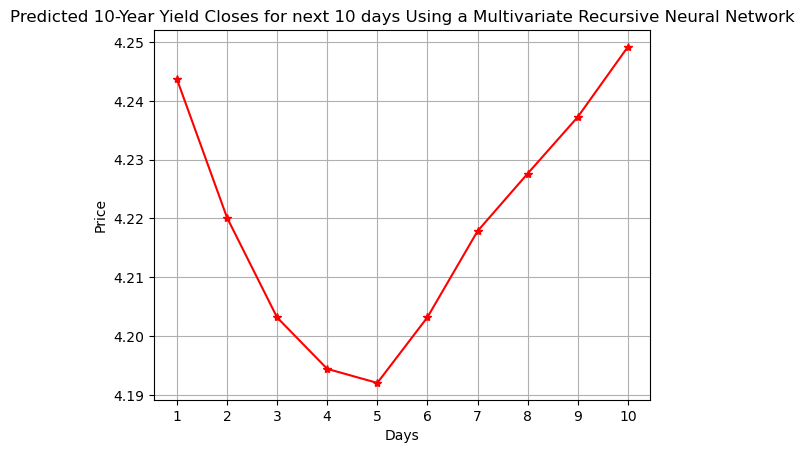

In [47]:
fig, ax = plt.subplots()

plt.plot(predictions_next_10_days, marker = '*', color = 'red')
plt.title(f'Predicted 10-Year Yield Closes for next 10 days Using a Multivariate Recursive Neural Network')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 10), ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.grid()

plt.show()

The model's train and test set go from 1/1/1985 to 12/1/2023... Ever since 12/1/2023, we've had four days worth of closes... Let's see if those five closes align at all with the above prediction.

In [48]:
ten_yield_test = get_data("^TNX", start_date = "12/2/2023", end_date = "12/8/2023",
                    index_as_date = True, interval = "1d")

predictions_final = predictions_next_10_days
predictions_final = predictions_final[0:4]
ten_yield_test = pd.DataFrame(ten_yield_test['close'])
ten_yield_test['Predictions'] = predictions_final
ten_yield_test

,close,Predictions
2023-12-04,4.288,4.243678
2023-12-05,4.171,4.220150
2023-12-06,4.121,4.203176
2023-12-07,4.129,4.194445


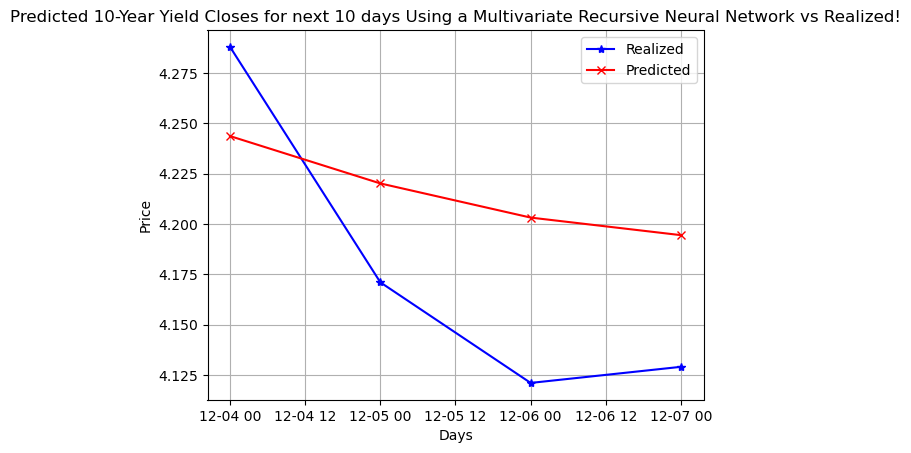

In [49]:
fig, ax = plt.subplots()

plt.plot(ten_yield_test['close'], marker = '*', color = 'blue', label = 'Realized')
plt.plot(ten_yield_test['Predictions'], marker = 'x', color = 'red', label = 'Predicted')
plt.title(f'Predicted 10-Year Yield Closes for next 10 days Using a Multivariate Recursive Neural Network vs Realized!')
plt.xlabel('Days')
plt.ylabel('Price')
ax.legend()
#plt.xticks(range(0, 10), ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.grid()

plt.show()

***Perhaps it may have over-estimated the magnitude.... but so far the model has gotten the directionality correct, at least! Even if the model is simplly able to just get a sense / feel for seasonality direction (rather than both direction and magnitude), this provides an enormous amount of value for me as a trader***

***Results Summary:***

In [50]:
# Calculate train data Univariate Model RMSE
print("MSE For Univariate Model Training Data is", math.sqrt(mean_squared_error(y_train,train_predict)))

# Calculate test data Univariate Model RMSE
print("MSE For Univariate Testing Data is", math.sqrt(mean_squared_error(y_test,test_predict)))

# Calculate train data Multivariate Model RMSE
print("MSE For Multivariate Model Training Data is", math.sqrt(mean_squared_error(y_train_multivar,train_predict_multivar)))

# Calculate test data Multivariate Model RMSE
print("MSE For Multivariate Model Training Data is", math.sqrt(mean_squared_error(y_test_multivar,test_predict_multivar)))

MSE For Univariate Model Training Data is 5.514073779161283
MSE For Univariate Testing Data is 2.262798248734188
MSE For Multivariate Model Training Data is 2.0229345975229074
MSE For Multivariate Model Training Data is 2.0039995966984043


## 8) Conclusions and Future Work

- Not only do we see that there is not a significant increase in model error in the testing data, but we see that the multivariate model in particular shows a level of consistency between the loss functions that would suggest a certain sense of generalizeability to this approach. That being said, just looking at the plot of the train data predicted values vs train data realized values for the multivariate model, you see that the predicted values for the training data are very far off from the realized values...

- Also another point to note is the difference in the complexity of predictions between the univariate model and the multivariate model (the univariate model seems to just run with the autocorrelation (which to be fair, is incredibly strong), while the multivariate model seems to better incorproate the seasonality of certain days, and recognizes the changing of direction).

- This may suggest that the model is trying to 'optimize' for the validation set (the test data) and therefore is coming up with predictions for training data that are materially lower than estimations on the testing data (I think that this is partially a function of the time series data: the values for the validation set were higher than the values for the training set (given we are in a different interest rate environment than a good majority of the training set, and to optimize for that, the model is adjusting predicted values). Running on different sequences of validation data (maintaining temporal relation ships, but using multiple time frames taken independently, if possible) could be an area for further work. 


- Additionally, a higher complexity model (with more layers, and more hyper parameter tuning) could be a an area for further work as well. In this exercise, I simply did not have the capacity to explore different types of parameter and hyperparameter tuning (the model on its own took long enough to train), and would want to experiment with different drop out levels, different unit sizes, different look backs for the LSTMs (different regimes) and additional layers in the network itself to see if it improves predictive capability. Stepping further back, I would also like to try a) different types of optimizers (using adam now, but would want to try Stochastic Gradient Descent as well more systematically) b) increase the number of epochs and increase patience threshold for early stopping (to see if the model experiences double descent), and explore with different batch sizes. 


- Finally, I would also want to try exploring various macro-parameters of the model; in essence, I would want to look at whether or not there are other fundamental macroeconomic variables I can incorporate into the model to increase the multivariate complexity (i.e. inflation data, economic growth data, demographic data, and other macro-financial asset time series like gold, USD strength and FX, and risky assets (credit and stocks)). This would help me both from an academic and professional lense, and will be the subject for further exploration. 